In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Import Goodgle stock data

In [2]:
dataset = pd.read_csv('Google_Stock_Price_Train.csv',index_col="Date",parse_dates=True)

In [3]:
# show the top of the dataframe
dataset.head()

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03,325.25,332.83,324.97,663.59,"7,380,500"
2012-01-04,331.27,333.87,329.08,666.45,"5,749,400"
2012-01-05,329.83,330.75,326.89,657.21,"6,590,300"
2012-01-06,328.34,328.77,323.68,648.24,"5,405,900"
2012-01-09,322.04,322.29,309.46,620.76,"11,688,800"


In [4]:
# check that all entries are valid and there is no empty entry
dataset.isna().any()

Open      False
High      False
Low       False
Close     False
Volume    False
dtype: bool

In [5]:
# printout some info about the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2012-01-03 to 2016-12-30
Data columns (total 5 columns):
Open      1258 non-null float64
High      1258 non-null float64
Low       1258 non-null float64
Close     1258 non-null object
Volume    1258 non-null object
dtypes: float64(3), object(2)
memory usage: 59.0+ KB


Note that `Close` and `Volume` are not float64, so we should modify them

In [6]:
# note that we can run this only once...
dataset["Close"] = dataset["Close"].str.replace(',', '').astype(float)
dataset["Volume"] = dataset["Volume"].str.replace(',', '').astype(float)

In [7]:
# now everything is float!
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2012-01-03 to 2016-12-30
Data columns (total 5 columns):
Open      1258 non-null float64
High      1258 non-null float64
Low       1258 non-null float64
Close     1258 non-null float64
Volume    1258 non-null float64
dtypes: float64(5)
memory usage: 59.0 KB


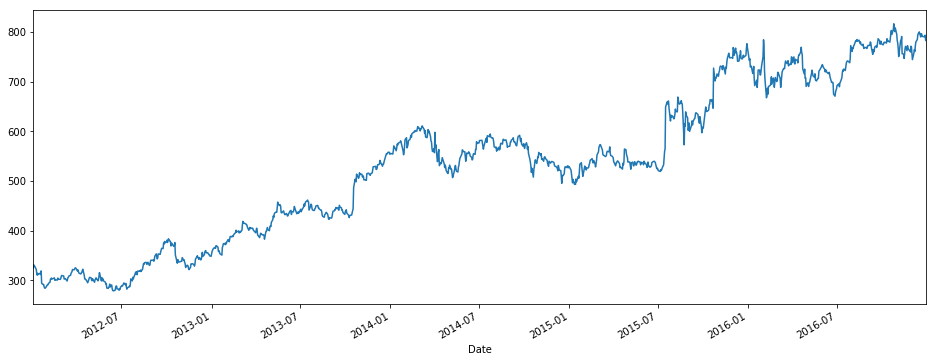

In [8]:
dataset['Open'].plot(figsize=(16,6))

In [9]:
# 7 day rolling mean
dataset.rolling(7).mean().head(20)

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03,NaN,NaN,NaN,NaN,NaN
2012-01-04,NaN,NaN,NaN,NaN,NaN
2012-01-05,NaN,NaN,NaN,NaN,NaN
2012-01-06,NaN,NaN,NaN,NaN,NaN
2012-01-09,NaN,NaN,NaN,NaN,NaN
2012-01-10,NaN,NaN,NaN,NaN,NaN
2012-01-11,323.002857,325.392857,318.682857,643.132857,7.208100e+06
2012-01-12,321.457143,322.882857,316.841429,638.037143,6.691514e+06
2012-01-13,318.698571,319.801429,314.025714,631.870000,6.531857e+06


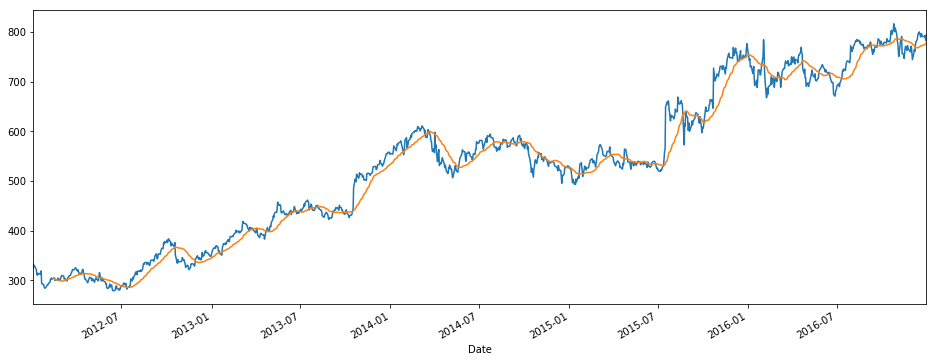

In [10]:
dataset['Open'].plot(figsize=(16,6))
dataset.rolling(window=30).mean()['Open'].plot()

In [11]:
# preparingn the training set
training_set=dataset['Open']
training_set=pd.DataFrame(training_set)
training_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2012-01-03 to 2016-12-30
Data columns (total 1 columns):
Open    1258 non-null float64
dtypes: float64(1)
memory usage: 19.7 KB


In [12]:
# scale (normalize) the training data
from sklearn.preprocessing import MinMaxScaler

# the MinMaxScaler basically takes the min value and set it
# to 0 and the max value to 1
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# note that training_set_scaled is a numpy array now

Ok, now we need to create a more suitable datastructure.
Recall that `training_set_scaled` contains an numpy array of the _scaled_ Open market value.
Let's say that we want to observe the market for 60 days and predict the Open markete value at day 61. More in general, we want to predict the Open market value of today using the Open values of the last 60 days.
To do that, we create arrays with 60 timesteps and 1 output.

In [13]:
x_train = []
y_train = []
ndays = len(training_set_scaled)
# fill in x and y
for i in range(60,ndays):
    x_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])

# note that X_train is a different name
X_train, y_train = np.array(x_train), np.array(y_train)
# reshaping for later use
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

Now we start with the serious stuff, building the recurrent neural network!

In [14]:
# Import the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [15]:
# Initialize the RNN: Sequential means that layers are added one after 
# the other connecting every layer to the next. Note that this is
# still a recurrent neural network because the history at timestep t-1
# is used as input at time t
neural_net = Sequential()

Now we need to add the layers. Here I have little idea why we use these many and with these parameters, I am just following the tutorial...

In [16]:
# Add the first LSTM layer and some Dropout regularisation
neural_net.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
neural_net.add(Dropout(0.2))

# Add a second LSTM layer and some Dropout regularisation
neural_net.add(LSTM(units = 50, return_sequences = True))
neural_net.add(Dropout(0.2))

# Add a third LSTM layer and some Dropout regularisation
neural_net.add(LSTM(units = 50, return_sequences = True))
neural_net.add(Dropout(0.2))

# Add a fourth LSTM layer and some Dropout regularisation
neural_net.add(LSTM(units = 50))
neural_net.add(Dropout(0.2))

# Add the output layer
neural_net.add(Dense(units = 1))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
# Compile the RNN
neural_net.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fit the RNN to the Training set
neural_net.fit(X_train, y_train, epochs = 100, batch_size = 32)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1198/1198 [==============================] - 7s 6ms/step - loss: 0.0538
Epoch 2/100
1198/1198 [==============================] - 5s 4ms/step - loss: 0.0062
Epoch 3/100
1198/1198 [==============================] - 5s 4ms/step - loss: 0.0052
Epoch 4/100
1198/1198 [==============================] - 5s 4ms/step - loss: 0.0051
Epoch 5/100
1198/1198 [==============================] - 5s 4ms/step - loss: 0.0049
Epoch 6/100
1198/1198 [==============================] - 5s 4ms/step - loss: 0.0050
Epoch 7/100
1198/1198 [==============================] - 5s 4ms/step - loss: 0.0049
Epoch 8/100
1198/1198 [==============================] - 5s 4ms/step - loss: 0.0044
Epoch 9/100
1198/1198 [==============================] - 5s 4ms/step - loss: 0.0040
Epoch 10/100
1198/1198 [==============================] - 5s 4ms/step - loss: 0.0042
Epoch 11/100
1198/1198 [==============================] - 5s 4ms/step - loss: 0.0040
Epoch 12/100
1198/1198 [==

1198/1198 [==============================] - 5s 4ms/step - loss: 0.0016
Epoch 95/100
1198/1198 [==============================] - 5s 4ms/step - loss: 0.0015
Epoch 96/100
1198/1198 [==============================] - 5s 4ms/step - loss: 0.0016
Epoch 97/100
1198/1198 [==============================] - 5s 4ms/step - loss: 0.0015
Epoch 98/100
1198/1198 [==============================] - 5s 4ms/step - loss: 0.0015
Epoch 99/100
1198/1198 [==============================] - 5s 4ms/step - loss: 0.0015
Epoch 100/100
1198/1198 [==============================] - 5s 4ms/step - loss: 0.0017


Now that we have trained the RNN, we can test it with some test data!

In [18]:
# Getting the real stock price of 2017
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv',index_col="Date",parse_dates=True)
real_stock_price = dataset_test.iloc[:, 1:2].values
dataset_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20 entries, 2017-01-03 to 2017-01-31
Data columns (total 5 columns):
Open      20 non-null float64
High      20 non-null float64
Low       20 non-null float64
Close     20 non-null float64
Volume    20 non-null object
dtypes: float64(4), object(1)
memory usage: 960.0+ bytes


In [19]:
dataset_test["Volume"] = dataset_test["Volume"].str.replace(',', '').astype(float)
test_set=dataset_test['Open']
test_set=pd.DataFrame(test_set)

# Get the predicted stock price of 2017
dataset_total = pd.concat((dataset['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = neural_net.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [20]:
predicted_stock_price=pd.DataFrame(predicted_stock_price)
predicted_stock_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 1 columns):
0    20 non-null float32
dtypes: float32(1)
memory usage: 160.0 bytes


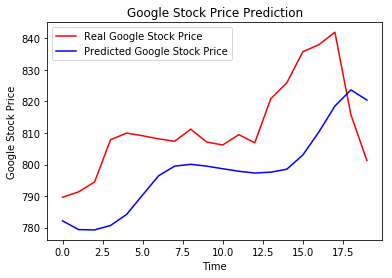

In [21]:
# Visualize the results
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()